In [253]:
from utils import *

# Load Data

### Load Untreated Biofilm and Release Cells

Loaded 6 release cells images from 'biofilm_data/release_cells/Untreated'


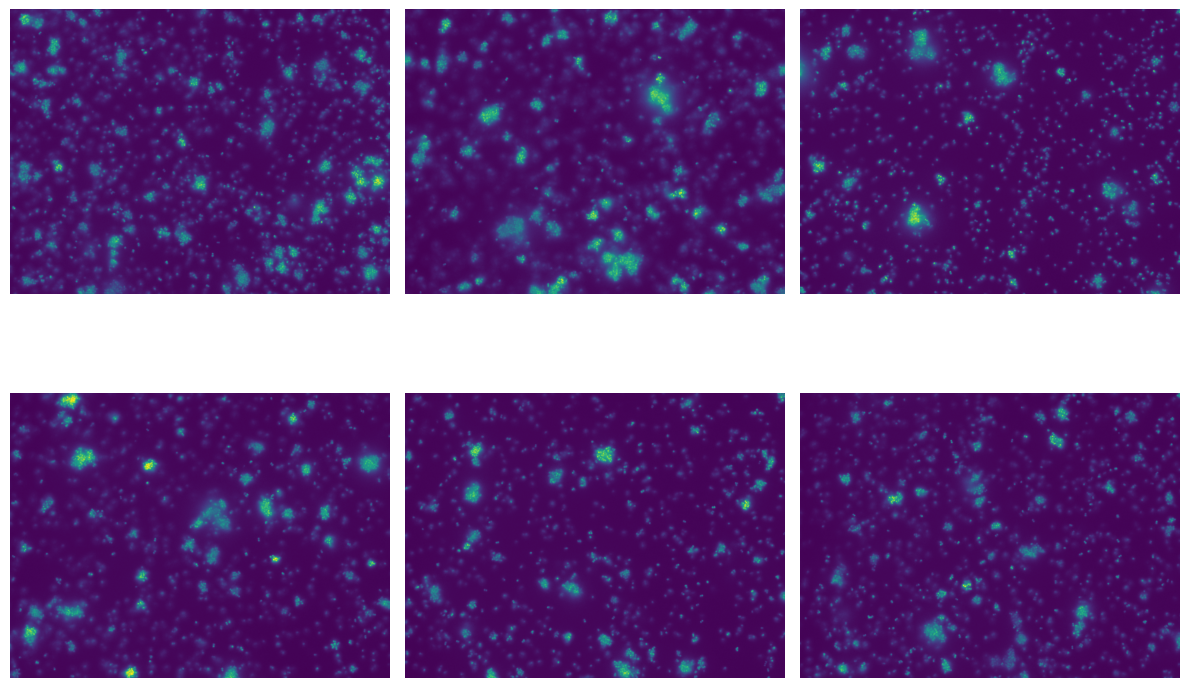

In [254]:
untreated_release = [normalize(grayscale(image)) for image in load_images('biofilm_data/release_cells/Untreated')]

print(f"Loaded {len(untreated_release)} release cells images from 'biofilm_data/release_cells/Untreated'")
display_grid_of_images(untreated_release)

### Load NaIO4 Release Cell Images

Loaded 6 release cells images from 'biofilm_data/release_cells/NaIO4'


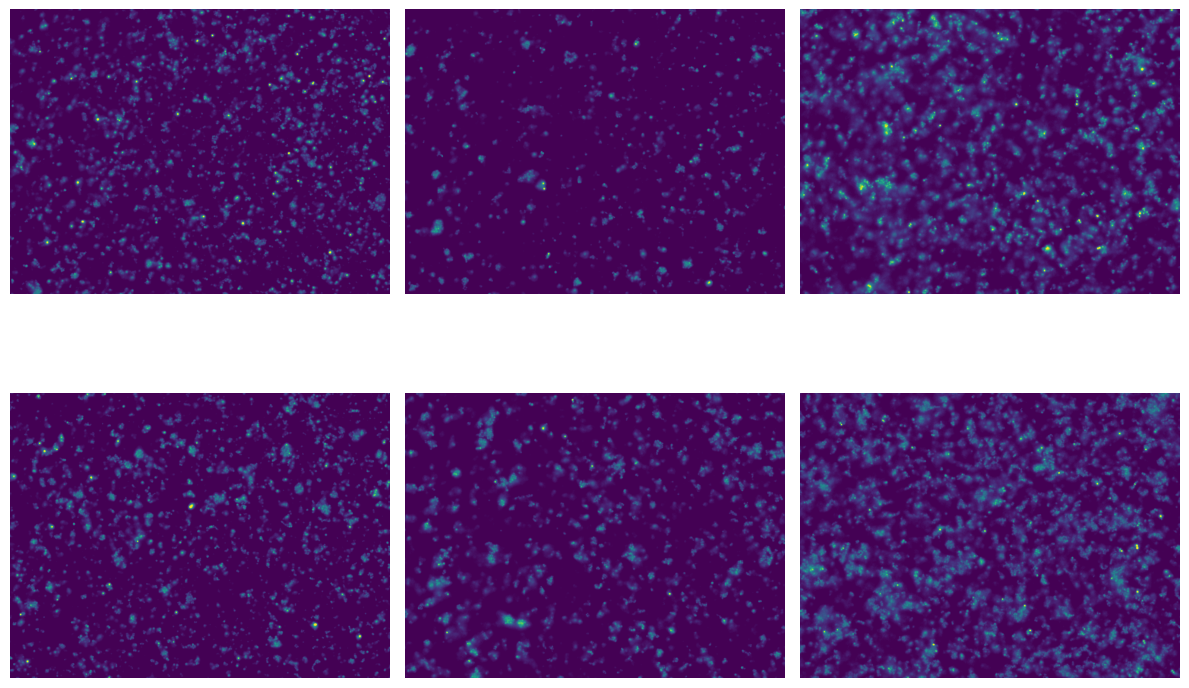

In [255]:
naio4_release = [normalize(grayscale(image)) for image in load_images('biofilm_data/release_cells/NaIO4')]

# limit the number of images to 6 for testing
naio4_release = naio4_release[:6]

print(f"Loaded {len(naio4_release)} release cells images from 'biofilm_data/release_cells/NaIO4'")
display_grid_of_images(naio4_release)

### Add treatment labels to images

In [256]:
labeled_untreated_release = [(image, "Untreated") for image in untreated_release]
labeled_naio4_release = [(image, "NaIO4") for image in naio4_release]

### Split into Train and Test

In [257]:
from sklearn.model_selection import train_test_split

labeled_release = labeled_untreated_release + labeled_naio4_release

release_train, release_test = train_test_split(labeled_release, test_size=0.2, random_state=42)

print(f"Train release: {len(release_train)}")
print(f"Test release: {len(release_test)}")
print(release_train[0][0])
print(release_train[0][1])

Train release: 9
Test release: 3
[[0.08627451 0.08235294 0.0745098  ... 0.         0.         0.        ]
 [0.15686275 0.15686275 0.12941176 ... 0.         0.         0.        ]
 [0.25882353 0.30980392 0.25098039 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.01176471 ... 0.         0.         0.        ]
 [0.         0.00784314 0.01568627 ... 0.         0.         0.        ]]
NaIO4


# Data Augmentation

## Create Square Patches

### Display example of patched image

Example: Original image (normalized grayscale) and its patches:


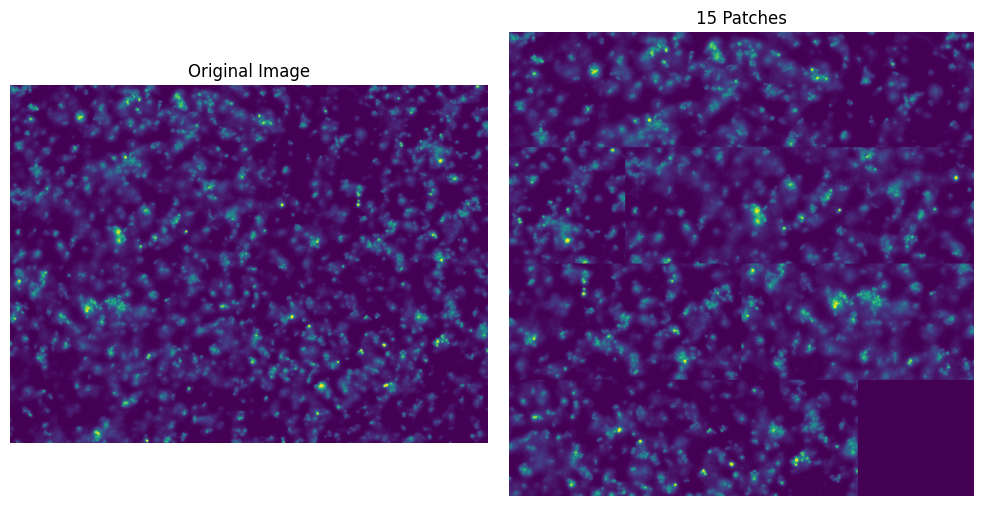

In [258]:
import matplotlib.pyplot as plt

# Show first untreated image before patching and a grid of its patches side by side
print("Example: Original image (normalized grayscale) and its patches:")

patches_from_first_img = extract_patches([release_train[0][0]], patch_size)
n_patches = min(16, len(patches_from_first_img))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Show original image
axes[0].imshow(release_train[0][0])
axes[0].set_title("Original Image")
axes[0].axis('off')

# Show patches as grid on the right
grid_size = int(np.ceil(np.sqrt(n_patches)))
for idx in range(n_patches):
    ax = plt.subplot(1, 2, 2)
    # Create small grid for the patches
    patch_grid = np.zeros((patch_size * grid_size, patch_size * grid_size))
    for ix in range(n_patches):
        gx = ix % grid_size
        gy = ix // grid_size
        patch = patches_from_first_img[ix]
        patch_grid[gy*patch_size:(gy+1)*patch_size, gx*patch_size:(gx+1)*patch_size] = patch
    ax.imshow(patch_grid)
    ax.set_title(f"{n_patches} Patches")
    ax.axis('off')
    break  # only need one subplot (right side)

plt.tight_layout()
plt.show()

### Create patches of size 128x128 of all data

In [259]:
patch_size = 128

patched_release_train = [
    (patch, label)
    for image, label in release_train
    for patch in extract_patches([image], patch_size)
]

patched_release_test = [
    (patch, label)
    for image, label in release_test
    for patch in extract_patches([image], patch_size)
]

print(f"Length of release_train: {len(release_train)}")
print(f"Length of release_test: {len(release_test)}")
print(f"Length of patched_release_train: {len(patched_release_train)}")
print(f"Length of patched_release_test: {len(patched_release_test)}")

Length of release_train: 9
Length of release_test: 3
Length of patched_release_train: 135
Length of patched_release_test: 45


## Rotate images

### Example Rotation Display

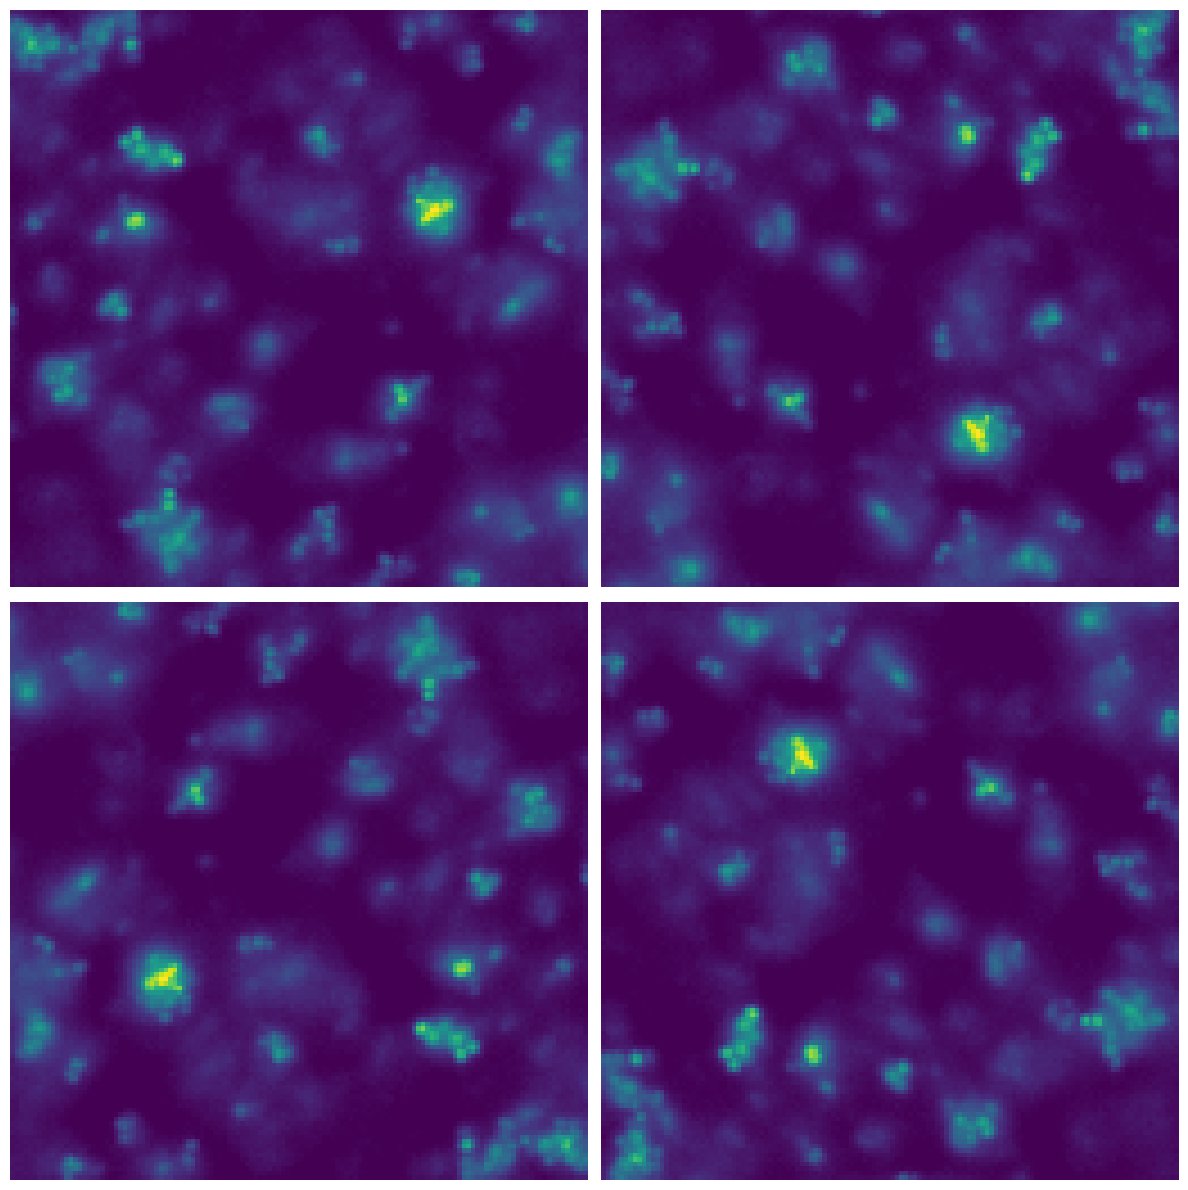

In [260]:
image = patched_release_train[0][0]
display_grid_of_images([image, cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE), cv2.rotate(image, cv2.ROTATE_180), cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)])

### Append Rotated Images to Data

In [261]:
print(f"Total number of patched images (train): {len(patched_release_train)}")
print(f"Total number of patched images (test): {len(patched_release_test)}")

for i in range(len(patched_release_train)):
    img, label = patched_release_train[i]
    patched_release_train.append((cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE), label))
    patched_release_train.append((cv2.rotate(img, cv2.ROTATE_180), label))
    patched_release_train.append((cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE), label))


for i in range(len(patched_release_test)): 
    img, label = patched_release_test[i]
    patched_release_test.append((cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE), label))
    patched_release_test.append((cv2.rotate(img, cv2.ROTATE_180), label))
    patched_release_test.append((cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE), label))

    


print(f"Total number of patched images after rotation (train): {len(patched_release_train)}")
print(f"Total number of patched images after rotation (test): {len(patched_release_test)}")


Total number of patched images (train): 135
Total number of patched images (test): 45
Total number of patched images after rotation (train): 540
Total number of patched images after rotation (test): 180


### Display total data for each treatment

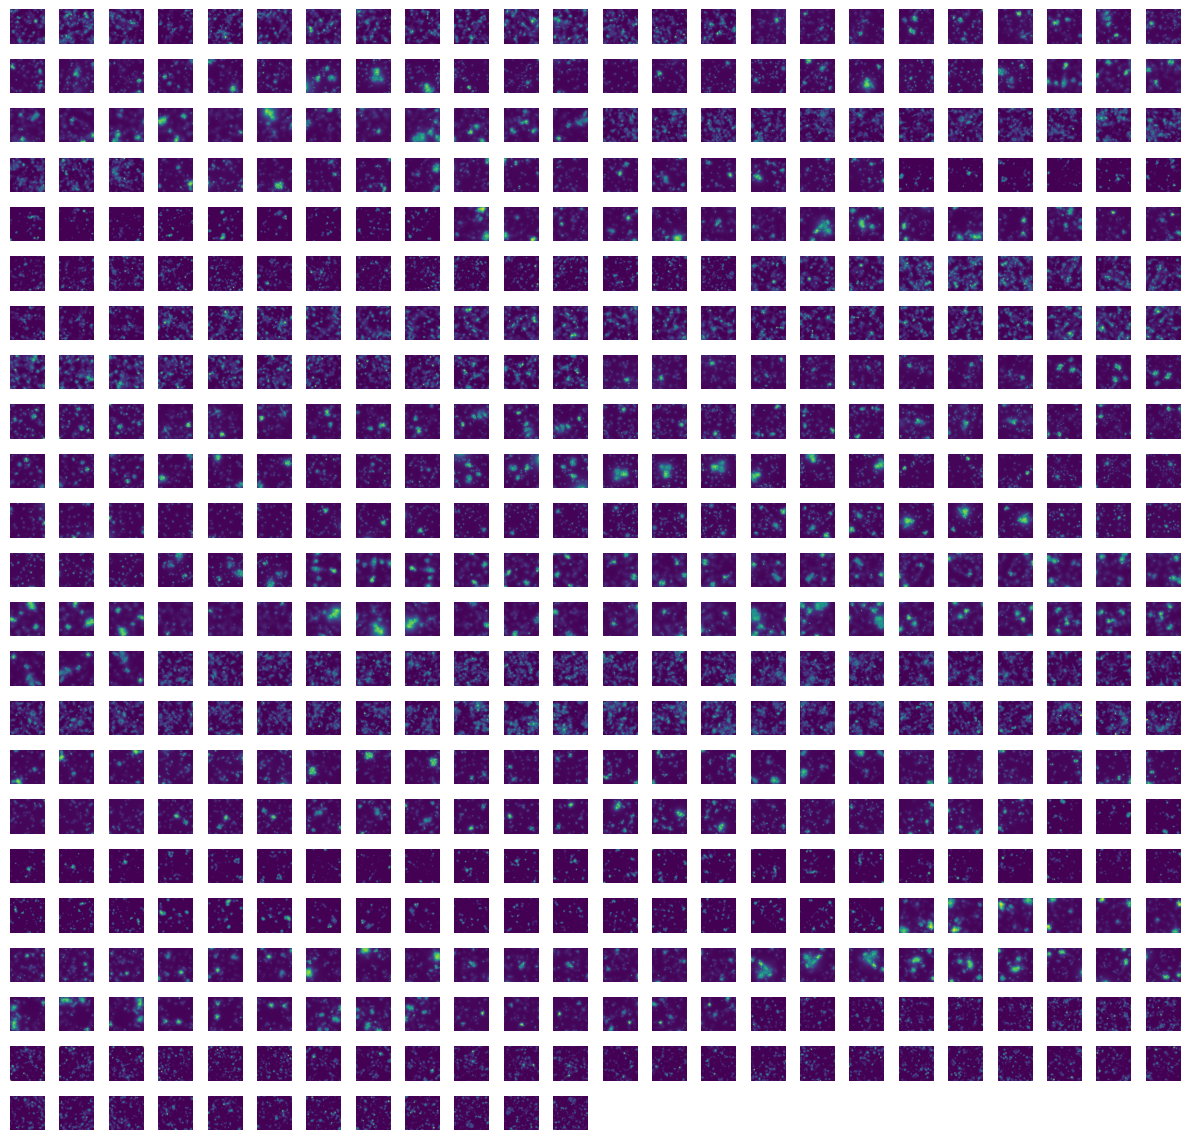

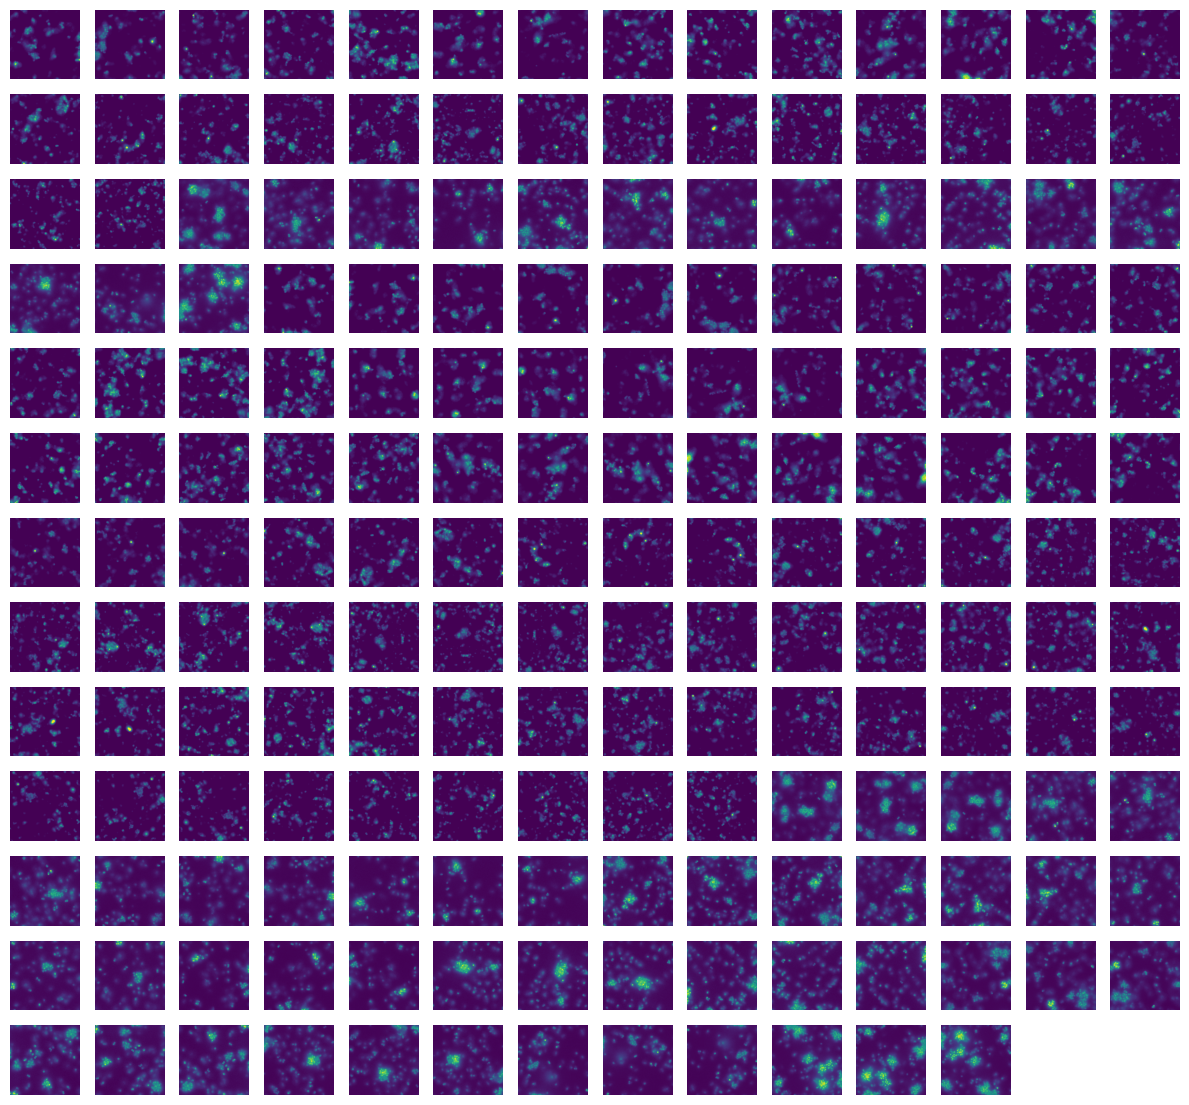

In [263]:
display_grid_of_images([image for image, _ in patched_release_train])
display_grid_of_images([image for image, _ in patched_release_test])

## Prepare Data for CNN

### Add labels to image lists

In [190]:
untreated_patched_labeled_images_train = [(image, "Untreated") for image in patched_untreated_images_train]
naio4_patched_labeled_images_train = [(image, "NaIO4") for image in patched_naio4_images_train]
untreated_patched_labeled_images_test = [(image, "Untreated") for image in patched_untreated_images_test]
naio4_patched_labeled_images_test = [(image, "NaIO4") for image in patched_naio4_images_test]

print(f"Untreated patched labeled images (train): {len(untreated_patched_labeled_images_train)}")
print(untreated_patched_labeled_images_train[0][0].shape)
print(untreated_patched_labeled_images_train[0][1])
print(f"NaIO4 patched labeled images (train): {len(naio4_patched_labeled_images_train)}")
print(naio4_patched_labeled_images_train[0][0].shape)
print(naio4__patched_labeled_images[0][1])
print(untreated_patched_labeled_images_test[0])

Untreated patched labeled images (train): 240
(128, 128)
Untreated
NaIO4 patched labeled images (train): 240
(128, 128)
NaIO4
(array([[0.04313725, 0.03529412, 0.04705882, ..., 0.0627451 , 0.05882353,
        0.05098039],
       [0.04705882, 0.05098039, 0.04705882, ..., 0.05882353, 0.0627451 ,
        0.05098039],
       [0.05098039, 0.05490196, 0.05490196, ..., 0.06666667, 0.05490196,
        0.05490196],
       ...,
       [0.03921569, 0.04313725, 0.05098039, ..., 0.05882353, 0.05882353,
        0.0627451 ],
       [0.03921569, 0.03921569, 0.04313725, ..., 0.05882353, 0.05882353,
        0.07058824],
       [0.03921569, 0.03921569, 0.03137255, ..., 0.05490196, 0.06666667,
        0.06666667]], shape=(128, 128)), 'Untreated')


### Create Tensors from pairs

In [193]:
import torch
from torchvision import transforms

# Combine your two lists
data_train = untreated_patched_labeled_images_train + naio4_patched_labeled_images_train
data_test = untreated_patched_labeled_images_test + naio4_patched_labeled_images_test

# Define transform
transform = transforms.ToTensor()  # converts 128x128 (H, W) → (1, 128, 128)

# Prepare tensors
images_train = torch.stack([transform(img) for img, _ in data_train])  # shape: (N, 1, 128, 128)
labels_train = torch.tensor([0 if label == "Untreated" else 1 for _, label in data_train])  # shape: (N,)
images_test = torch.stack([transform(img) for img, _ in data_test])  # shape: (N, 1, 128, 128)
labels_test = torch.tensor([0 if label == "Untreated" else 1 for _, label in data_test])  # shape: (N,)

print(f"Images shape: {images_train.shape}")
print(f"Labels shape: {labels_train.shape}")

Images shape: torch.Size([480, 1, 128, 128])
Labels shape: torch.Size([480])


In [184]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(images_train.float(), labels_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


# Create, Train, and Evaluate CNN

## Create CNN

In [185]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
   def __init__(self):
       super(CNN, self).__init__()

       self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
       self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
       self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
       self.fc1 = nn.Linear(16 * 32 * 32, 100) # 32 * 32 for 128x128 images that were pooled twice down to 32x32
       self.fc2 = nn.Linear(100, 2)


   def forward(self, x):
       x = F.relu(self.conv1(x))  # Apply first convolution and ReLU activation
       x = self.pool(x)           # Apply max pooling
       x = F.relu(self.conv2(x))  # Apply second convolution and ReLU activation
       x = self.pool(x)           # Apply max pooling
       x = x.reshape(x.shape[0], -1)  # Flatten the tensor
       x = self.fc1(x)            # Apply fully connected layer
       x = self.fc2(x)            # Apply fully connected layer
       return x

### Instantiate CNN, Criterion, and Optimizer

In [186]:
import torch.nn as nn
import torch.optim as optim

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training Loop

In [187]:
num_epochs = 15

for epoch in range(num_epochs):
    for X, y in dataloader:
        optimizer.zero_grad()      # reset gradients
        outputs = model(X)         # forward pass
        loss = criterion(outputs, y)  # compute loss
        loss.backward()            # backpropagate
        optimizer.step()           # update weights

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/15], Loss: 0.6793
Epoch [2/15], Loss: 0.6101
Epoch [3/15], Loss: 0.5485
Epoch [4/15], Loss: 0.2667
Epoch [5/15], Loss: 0.0504
Epoch [6/15], Loss: 0.0057
Epoch [7/15], Loss: 0.0035
Epoch [8/15], Loss: 0.0021
Epoch [9/15], Loss: 0.0024
Epoch [10/15], Loss: 0.0039
Epoch [11/15], Loss: 0.0009
Epoch [12/15], Loss: 0.0010
Epoch [13/15], Loss: 0.0006
Epoch [14/15], Loss: 0.0005
Epoch [15/15], Loss: 0.0009


### Evaluation

In [195]:
with torch.no_grad():
    # Evaluate training accuracy
    train_preds = model(images_train.float()).argmax(dim=1)
    train_acc = (train_preds == labels_train).float().mean()
    print(f"Training accuracy: {train_acc:.4f}")

    # Evaluate test accuracy (and error)
    test_preds = model(images_test.float()).argmax(dim=1)
    test_acc = (test_preds == labels_test).float().mean()
    print(f"Test accuracy: {test_acc:.4f}")

Training accuracy: 1.0000
Test accuracy: 0.9833
